## comentarios diego 
1. estamos usando una definición diferente de prate
    - diego 
        - $p_r = \frac{\sum_{m=2020-03}^{2021-03}{d_m-d_{m_{2019}}}}{n_{\rm{meses}}}$
            - $p_r$ -> death rate 
            - $m$ -> mes 2019
            - $m_{2019}$ -> mes 2019   
1. estamos usando una diferente medida de promedio mes

- cambiando (1) de tu notebook a mi definición y restringiendo el rango a 2020-03–2021-03 tenemos resultados similares 

In [27]:
import warnings
import datetime
import unidecode

import numpy as np
import pandas as pd
import seaborn as sns

import sklearn.linear_model
import statsmodels.formula.api as smf

from matplotlib import pyplot

warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

### Exceso mortalidad

In [28]:
mortality_df = pd.read_csv(
    'https://github.com/pr0nstar/covid19-data/raw/master/raw/mortality/south.america.subnational.mortality.csv'
)

In [29]:
mortality_df['date'] = pd.to_datetime(mortality_df['date'])

geo_codes = {'PY-{}'.format(_):'PY-0{}'.format(_) for _ in range(1, 10)}

mortality_df['adm1_isocode'] = mortality_df['adm1_isocode'].replace(geo_codes)
mortality_df = mortality_df.set_index(['iso_code', 'adm1_isocode', 'date'])
mortality_df = mortality_df.sort_index()

mortality_df.head(1)

,,,country_name,adm1_name,frequency,deaths
iso_code,adm1_isocode,date,,,,
BO,BO-B,2019-01-01,Bolivia,Beni,monthly,131


In [30]:
location_df = mortality_df.reset_index()[['country_name', 'adm1_name', 'adm1_isocode']]
location_df = location_df.drop_duplicates()

In [31]:
df_co = mortality_df.loc[['CO']].reset_index(level='date')
df_co['date'] = df_co['date'] - pd.DateOffset(days=1)
df_co = df_co.set_index('date', append=True)

mortality_df = mortality_df.drop('CO', level='iso_code')
mortality_df = pd.concat([mortality_df, df_co])

In [32]:
# https://en.wikipedia.org/wiki/2017_Mocoa_landslide
mortality_df.loc[('CO', 'CO-PUT', '2017-03-26'), 'deaths'] = 24

In [33]:
#### Drop Peru Lambayaque
mortality_df = mortality_df.drop(('PE', 'PE-LAM'))

#### Drop Peru Ayacucho 2017
df_pe_lam = mortality_df.xs(('PE', 'PE-AYA'), drop_level=False).reset_index(level='date')
df_pe_lam = df_pe_lam[df_pe_lam['date'] < '2018'].set_index('date', append=True)

mortality_df = mortality_df.drop(df_pe_lam.index)

In [34]:
#### Drop Brasil 2018
df_br = mortality_df.loc[['BR']].reset_index(level='date')
df_br = df_br[df_br['date'] < '2019'].set_index('date', append=True)

df = mortality_df.drop(df_br.index)

In [35]:
# Monthly
mortality_df = mortality_df.groupby([
    'adm1_isocode',
    pd.Grouper(level='date', freq='M')
])['deaths'].sum().unstack(level=0)

In [36]:
# Right censoring (two months)
mortality_df = mortality_df.iloc[:-2]
# 2016:
mortality_df = mortality_df.loc['2016':]

In [37]:
def get_base(df):
    base_df = df.loc['2019-01':'2019-12']
    
    base_df = base_df.to_frame().set_index([
        base_df.index.year, base_df.index.month
    ])[df.name]

    base_years = base_df.index.get_level_values(0).values.reshape(-1 ,1)
    base_years_n = len(np.unique(base_years))
    
    onehot = np.concatenate([np.eye(12) for _ in range(base_years_n)])
    predictors = np.concatenate((base_years, onehot), axis=1)

    reg = sklearn.linear_model.LinearRegression(fit_intercept=False).fit(
        predictors, base_df.values
    )
    
    baseline = reg.predict(
        np.concatenate((np.ones((12, 1)) * 2020, np.eye(12)), axis=1)
    )
    
    fbase_df = pd.DataFrame([])
    for year in df.loc['2020':].index.year.unique():
        indexed_base_df = pd.Series(baseline)
        indexed_base_df.index = pd.date_range(
            start=str(year), periods=12, freq='M'
        )
        fbase_df = pd.concat([fbase_df, indexed_base_df])

    return fbase_df[0].rename(df.name)[:df.index[-1]]


In [38]:
mortality_base_df = mortality_df.apply(lambda _: get_base(_.dropna()))

In [49]:
(mortality_df.loc['2020-03':'2021-03']/mortality_base_df).mean()

adm1_isocode
BO-B     1.555533
BO-C     1.308356
BO-H     1.232993
BO-L     1.806022
BO-N     1.966513
           ...   
UY-SA    0.914194
UY-SJ    0.981202
UY-SO    0.982369
UY-TA    0.903787
UY-TT    1.051720
Length: 170, dtype: float64

In [50]:
mortality_prate = mortality_total_diff = (mortality_df /mortality_base_df).loc['2020-03':'2021-03'].mean()

mortality_total_expected = mortality_base_df.apply(
    lambda _: _['2020-03':mortality_df[_.name].last_valid_index()].sum()
)

mortality_prate = (mortality_total_diff / mortality_total_expected)

In [51]:
mortality_prate

adm1_isocode
BO-B     1.555533
BO-C     1.308356
BO-H     1.232993
BO-L     1.806022
BO-N     1.966513
           ...   
UY-SA    0.914194
UY-SJ    0.981202
UY-SO    0.982369
UY-TA    0.903787
UY-TT    1.051720
Length: 170, dtype: float64

### Elevacion

In [82]:
elevation_df = pd.read_csv(
    'https://github.com/daliagachc/cov-alt/raw/master/data/city_data.csv',
    na_values='QuantityMagnitude[Missing["NotAvailable"]]'
)
elevation_df = elevation_df.dropna()
elevation_df.columns = [_.lower() for _ in elevation_df.columns]

elevation_df['elevation']=elevation_df['elevation']/1000

In [83]:
elevation_df.head()

,city,population,elevation,administrativedivision,country
0,Santa Cruz,1453549,0.42,"Santa Cruz, Bolivia",Bolivia
1,El Alto,903080,4.10,"La Paz, Bolivia",Bolivia
2,La Paz,757184,3.70,"La Paz, Bolivia",Bolivia
3,Cochabamba,632013,2.60,"Cochabamba, Bolivia",Bolivia
4,Sucre,300000,2.80,"Chuquisaca, Bolivia",Bolivia


In [84]:
elevation_adm1_map = {
    'Distrito Federal': 'Federal District',
    'Rio Grande Do Sul': 'Rio Grande do Sul',
    'Bio Bio': 'Biobio',
    'Metropolitana': 'Santiago Metropolitan',
    'Distrito Capital': 'Bogota D.C.',
    'Morona Santiago': 'Morona-Santiago',
    'Zamora Chinchipe': 'Zamora-Chinchipe',
    'Canendiyu': 'Canindeyu',
}

In [85]:
elevation_locations = elevation_df['administrativedivision'].str.split(',').apply(pd.Series)
elevation_locations = pd.concat([
    elevation_df['administrativedivision'],
    elevation_locations
], axis=1)
elevation_locations.columns = ['elevation_name', 'adm1_name', 'country_name']

elevation_locations = elevation_locations.drop_duplicates()
elevation_locations = elevation_locations.applymap(lambda _: _.strip())

elevation_locations['adm1_name'] = elevation_locations['adm1_name'].apply(unidecode.unidecode)
elevation_locations['adm1_name'] = elevation_locations['adm1_name'].replace(elevation_adm1_map)

elevation_locations.head()

,elevation_name,adm1_name,country_name
0,"Santa Cruz, Bolivia",Santa Cruz,Bolivia
1,"La Paz, Bolivia",La Paz,Bolivia
3,"Cochabamba, Bolivia",Cochabamba,Bolivia
4,"Chuquisaca, Bolivia",Chuquisaca,Bolivia
5,"Oruro, Bolivia",Oruro,Bolivia


In [86]:
elevation_locations = pd.concat([
    location_df.set_index(['country_name', 'adm1_name']),
    elevation_locations.set_index(['country_name', 'adm1_name'])
], axis=1)

In [87]:
elevation_locations[elevation_locations.isna().any(axis=1)]

adm1_isocode  \
country_name adm1_name                                     
Chile        Arica y Parinacota                    CL-AP   
             Libertador                              NaN   
             O'Higgins                             CL-LI   
             Ñuble                                 CL-NB   
Ecuador      Santa Elena                           EC-SE   
             Santo Domingo de los Tsachilas        EC-SD   
Peru         Callao                               PE-CAL   
             Lima Provincias                         NaN   

                                                    elevation_name  
country_name adm1_name                                              
Chile        Arica y Parinacota                                NaN  
             Libertador                          Libertador, Chile  
             O'Higgins                                         NaN  
             Ñuble                                             NaN  
Ecuador      Santa Elena                                       NaN  
             Santo Domingo de los Tsachilas                    NaN  
Peru         Callao                                            NaN  
             Lima Provincias                 Lima Provincias, Peru

In [88]:
# Population weighted

population_weighted_elevation = elevation_df.groupby('administrativedivision').apply(
    lambda _: (_['population'] * _['elevation']).sum() / _['population'].sum()
).round(3)

elevation_df_ = elevation_df.groupby('administrativedivision').apply(
    lambda _: (_['population'] * np.log(_['elevation'] + 1e-6)).sum() / _['population'].sum()
)
elevation_df_ = np.exp(elevation_df_).round(3)

population_weighted_elevation = pd.concat([
    population_weighted_elevation.rename('elevation_arithmetic'),
    elevation_df_.rename('elevation_geometric'),
    elevation_df.groupby('administrativedivision')['population'].sum()
], axis=1)

population_weighted_elevation.head()

,elevation_arithmetic,elevation_geometric,population
administrativedivision,,,
"Acre, Brazil",0.150,0.149,531527
"Aisen, Chile",0.280,0.280,57818
"Alagoas, Brazil",0.099,0.043,2352063
"Alto Paraguay, Paraguay",0.094,0.089,13120
"Alto Parana, Paraguay",0.222,0.221,550795


In [89]:
population_weighted_elevation.index = population_weighted_elevation.index.to_series().replace(
    elevation_locations.set_index('elevation_name')['adm1_isocode']
)
population_weighted_elevation = pd.concat([
    population_weighted_elevation[~population_weighted_elevation.index.isna()],
    mortality_prate.rename('prate'),
    location_df.set_index('adm1_isocode')
], axis=1).dropna()

In [90]:
population_weighted_elevation

,elevation_arithmetic,elevation_geometric,population,prate,country_name,adm1_name
BR-AC,0.150,0.149,531527.0,1.423198,Brazil,Acre
CL-AI,0.280,0.280,57818.0,1.177704,Chile,Aisen
BR-AL,0.099,0.043,2352063.0,1.225770,Brazil,Alagoas
PY-16,0.094,0.089,13120.0,1.842985,Paraguay,Alto Paraguay
PY-10,0.222,0.221,550795.0,1.309568,Paraguay,Alto Parana
...,...,...,...,...,...,...
CO-VAC,0.904,0.555,4539294.0,1.281904,Colombia,Valle del Cauca
CL-VS,0.165,0.085,1376910.0,1.153106,Chile,Valparaiso
CO-VAU,0.184,0.182,16374.0,1.163810,Colombia,Vaupes
CO-VID,0.081,0.076,18502.0,1.166058,Colombia,Vichada


### Exceso/Elevacion

In [91]:
PAISES_ANDINOS = [
    'Bolivia', 'Peru', 'Ecuador', 'Colombia'
]

In [92]:
paises_andinos_df = population_weighted_elevation[
    population_weighted_elevation['country_name'].isin(PAISES_ANDINOS)
]

In [93]:
#remove galapagos
paises_andinos_df=paises_andinos_df[paises_andinos_df['prate']<3]

<AxesSubplot:xlabel='elevation_geometric', ylabel='prate'>

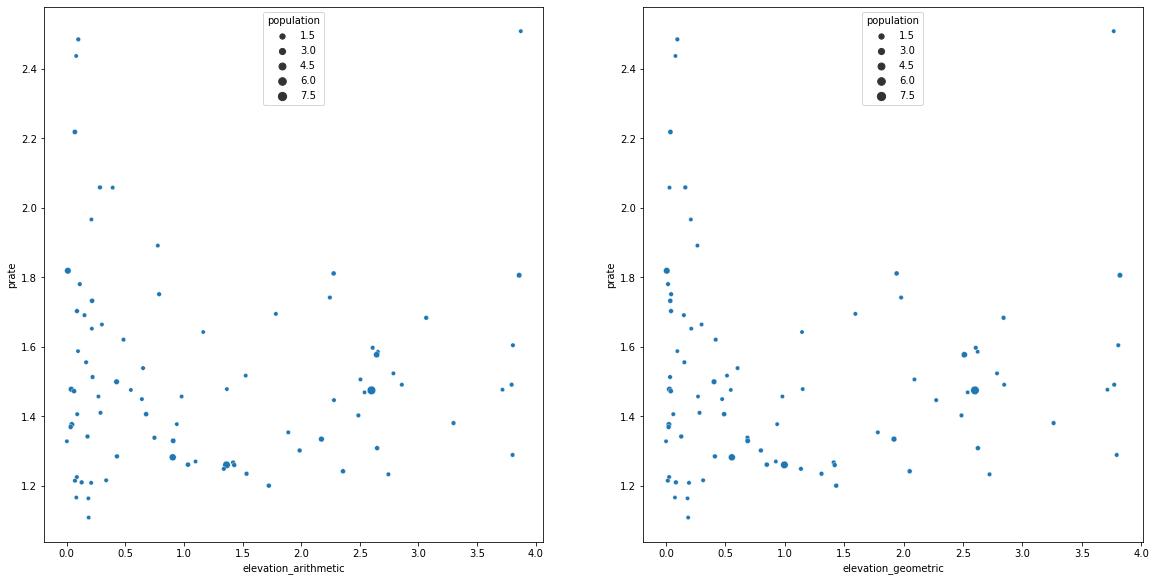

In [94]:
fig, axs = pyplot.subplots(figsize=(50/2.54, 25/2.54), ncols=2)

sns.scatterplot(data=paises_andinos_df, x='elevation_arithmetic', y='prate', size='population', ax=axs[0])
sns.scatterplot(data=paises_andinos_df, x='elevation_geometric', y='prate', size='population', ax=axs[1])


In [95]:
smf.ols('prate ~ elevation_arithmetic', data=paises_andinos_df).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  prate   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.012
Method:                 Least Squares   F-statistic:                  0.006833
Date:                Thu, 30 Dec 2021   Prob (F-statistic):              0.934
Time:                        12:37:39   Log-Likelihood:                -15.083
No. Observations:                  85   AIC:                             34.17
Df Residuals:                      83   BIC:                             39.05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                1.5174      0.046     33.142      0.000       1.426       1.608
elevation_arithmetic    -0.0022      0.027     -0.083      0.934      -0.055       0.051
==============================================================================
Omnibus:                       31.532   Durbin-Watson:                   1.968
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               54.629
Skew:                           1.497   Prob(JB):                     1.37e-12
Kurtosis:                       5.542   Cond. No.                         2.98
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [96]:
smf.ols('prate ~ elevation_geometric', data=paises_andinos_df).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  prate   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.012
Method:                 Least Squares   F-statistic:                  0.008460
Date:                Thu, 30 Dec 2021   Prob (F-statistic):              0.927
Time:                        12:37:40   Log-Likelihood:                -15.082
No. Observations:                  85   AIC:                             34.16
Df Residuals:                      83   BIC:                             39.05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               1.5174      0.044     34.810      0.000       1.431       1.604
elevation_geometric    -0.0025      0.027     -0.092      0.927      -0.056       0.051
==============================================================================
Omnibus:                       31.546   Durbin-Watson:                   1.967
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               54.695
Skew:                           1.497   Prob(JB):                     1.33e-12
Kurtosis:                       5.546   Cond. No.                         2.71
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [97]:
paises_andinos_df_ = paises_andinos_df.copy()

paises_andinos_df_ = pd.merge(
    paises_andinos_df_.groupby('country_name').median(), paises_andinos_df,
    left_on='country_name',
    right_on='country_name',
    suffixes=['_country','']
)

In [98]:
paises_andinos_df_['prate'] = paises_andinos_df_['prate'] - paises_andinos_df_['prate_country']

<AxesSubplot:xlabel='elevation_geometric', ylabel='prate'>

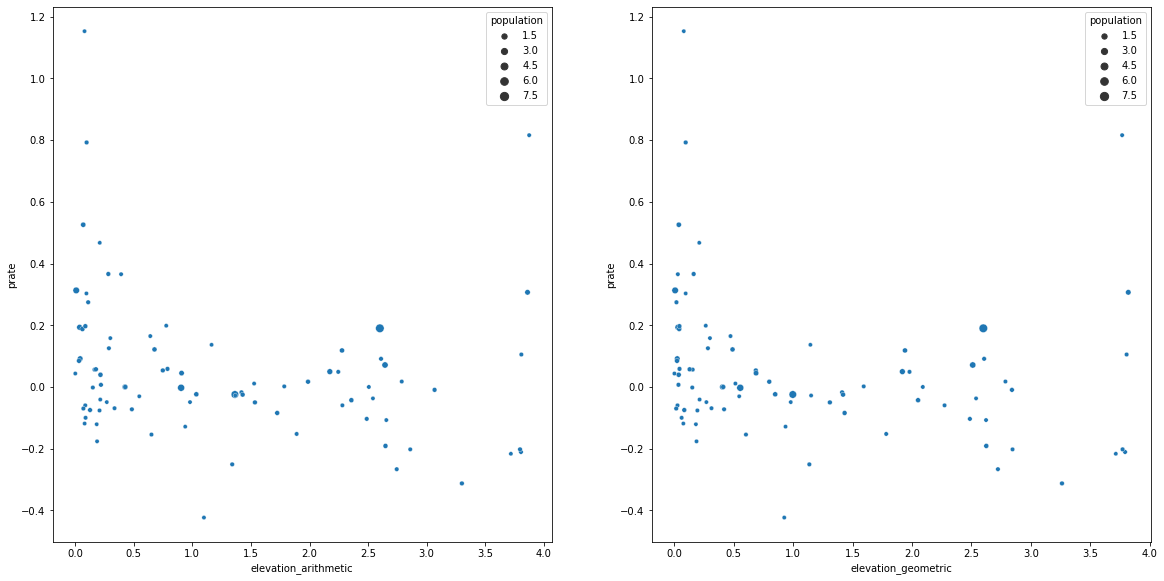

In [99]:
fig, axs = pyplot.subplots(figsize=(50/2.54, 25/2.54), ncols=2)

sns.scatterplot(data=paises_andinos_df_, x='elevation_arithmetic', y='prate', size='population', ax=axs[0])
sns.scatterplot(data=paises_andinos_df_, x='elevation_geometric', y='prate', size='population', ax=axs[1])

In [100]:
smf.ols('prate ~ elevation_arithmetic', data=paises_andinos_df_).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  prate   R-squared:                       0.050
Model:                            OLS   Adj. R-squared:                  0.039
Method:                 Least Squares   F-statistic:                     4.385
Date:                Thu, 30 Dec 2021   Prob (F-statistic):             0.0393
Time:                        12:37:51   Log-Likelihood:                 4.1399
No. Observations:                  85   AIC:                            -4.280
Df Residuals:                      83   BIC:                            0.6055
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                0.1021      0.037      2.796      0.006       0.029       0.175
elevation_arithmetic    -0.0446      0.021     -2.094      0.039      -0.087      -0.002
==============================================================================
Omnibus:                       54.447   Durbin-Watson:                   1.993
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              210.197
Skew:                           2.092   Prob(JB):                     2.27e-46
Kurtosis:                       9.469   Cond. No.                         2.98
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [101]:
smf.ols('prate ~ elevation_geometric', data=paises_andinos_df_).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  prate   R-squared:                       0.049
Model:                            OLS   Adj. R-squared:                  0.037
Method:                 Least Squares   F-statistic:                     4.256
Date:                Thu, 30 Dec 2021   Prob (F-statistic):             0.0422
Time:                        12:38:20   Log-Likelihood:                 4.0771
No. Observations:                  85   AIC:                            -4.154
Df Residuals:                      83   BIC:                            0.7310
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.0962      0.035      2.765      0.007       0.027       0.165
elevation_geometric    -0.0441      0.021     -2.063      0.042      -0.087      -0.002
==============================================================================
Omnibus:                       55.335   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              217.691
Skew:                           2.125   Prob(JB):                     5.36e-48
Kurtosis:                       9.589   Cond. No.                         2.71
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""